<a href="https://colab.research.google.com/github/fcoliveira-utfpr/climate_parana/blob/main/climate_dominance_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start – Libraries
---

In [1]:
# =========================================================
# REQUIRED LIBRARIES
# =========================================================
# -------------------------
# IMPORTS
# -------------------------
!pip install geobr geopandas rasterio elevation cartopy matplotlib-scalebar --quiet
# =========================================================
# IMPORT REQUIRED LIBRARIES
# =========================================================
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import geobr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.0/338.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.9 MB/s eta 0:00:00


/tmp/ipython-input-3720024649.py:46: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df_dom['dom_clima'] = df_dom[['hid_def', 'hid_exc', 'termico']].idxmax(axis=1)
/usr/local/lib/python3.12/dist-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(


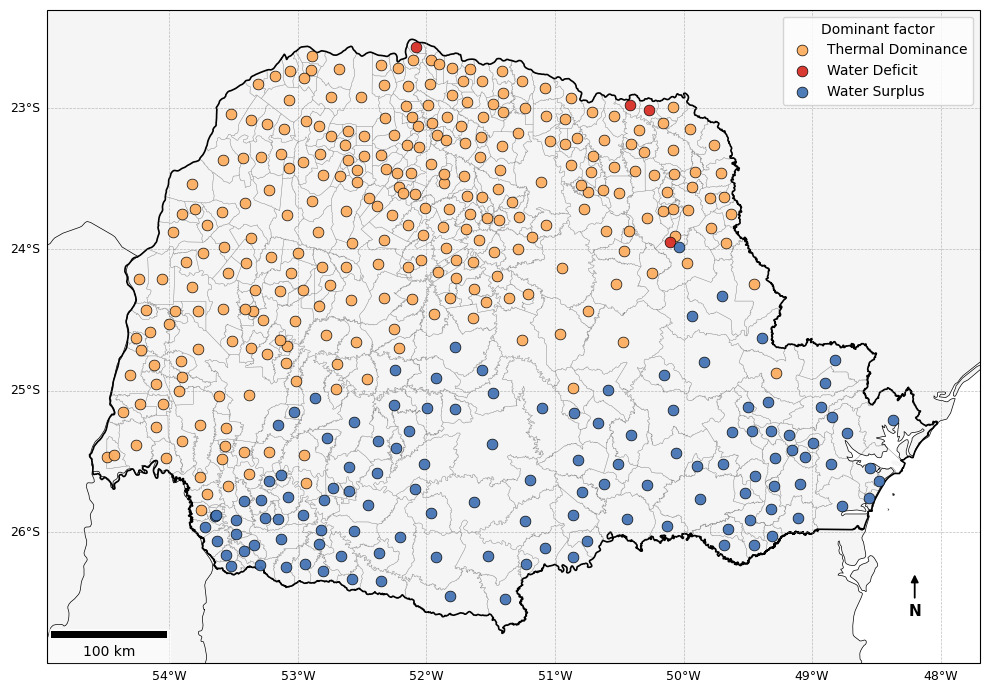

In [6]:
# =========================================================
# IMPORT LIBRARIES
# =========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import geobr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from geobr import read_municipality
from matplotlib_scalebar.scalebar import ScaleBar

# =========================================================
# LOAD DATA
# =========================================================
url = "https://raw.githubusercontent.com/fcoliveira-utfpr/climate_parana/refs/heads/main/dados_concatenados_zc.csv"
df = pd.read_csv(url, sep=",")

df['variavel'] = df['variavel'].str.lower()

df_clima = (
    df.pivot_table(
        index=['estado', 'municipio', 'lat', 'lon', 'ZC'],
        columns='variavel',
        values='valor',
        aggfunc='mean'
    )
    .reset_index()
)

df_dom = df_clima.copy()

# =========================================================
# NORMALIZATION (0–1)
# =========================================================
for v in ['def', 'ro', 'pet', 'tmmx']:
    df_dom[v + '_n'] = (
        df_dom[v] - df_dom[v].min()
    ) / (df_dom[v].max() - df_dom[v].min())

df_dom['hid_def'] = df_dom['def_n']
df_dom['hid_exc'] = df_dom['ro_n']
df_dom['termico'] = 0.5 * df_dom['pet_n'] + 0.5 * df_dom['tmmx_n']

df_dom['dom_clima'] = df_dom[['hid_def', 'hid_exc', 'termico']].idxmax(axis=1)

dom_clima_mapping = {
    'hid_def': 'Water Deficit',
    'hid_exc': 'Water Surplus',
    'termico': 'Thermal Dominance'
}

df_dom['dom_clima'] = df_dom['dom_clima'].replace(dom_clima_mapping)

# =========================================================
# LOAD STATE AND MUNICIPAL BOUNDARIES
# =========================================================
pr = geobr.read_state(code_state='PR', year=2020).to_crs(epsg=4326)
mun_pr = read_municipality(code_muni="PR", year=2020).to_crs(epsg=4326)

# =========================================================
# CREATE MAP
# =========================================================
fig = plt.figure(figsize=(10, 9))
ax = plt.axes(projection=ccrs.PlateCarree())

# Extent with small margin
minx, miny, maxx, maxy = pr.total_bounds
dx = (maxx - minx) * 0.05
dy = (maxy - miny) * 0.05

ax.set_extent(
    [minx - dx, maxx + dx, miny - dy, maxy + dy],
    crs=ccrs.PlateCarree()
)

# Background
ax.add_feature(cfeature.LAND, facecolor='#F5F5F5')
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)

# =========================================================
# MUNICIPAL LIMITS (thin)
# =========================================================
mun_pr.boundary.plot(
    ax=ax,
    edgecolor='gray',
    linewidth=0.3,
    alpha=0.6,
    transform=ccrs.PlateCarree(),
    zorder=1
)

# =========================================================
# STATE BOUNDARY (highlighted)
# =========================================================
pr.boundary.plot(
    ax=ax,
    edgecolor='black',
    linewidth=1.2,
    transform=ccrs.PlateCarree(),
    zorder=2
)

# =========================================================
# COLOR SCHEME
# =========================================================
colors = {
    'Water Deficit': '#d73027',
    'Water Surplus': '#4575b4',
    'Thermal Dominance': '#fdae61'
}

# =========================================================
# PLOT POINTS
# =========================================================
for c, g in df_dom.groupby('dom_clima'):
    ax.scatter(
        g['lon'],
        g['lat'],
        s=60,
        color=colors[c],
        edgecolor='black',
        linewidth=0.5,
        alpha=0.95,
        label=c,
        transform=ccrs.PlateCarree(),
        zorder=5
    )

# =========================================================
# GRIDLINES
# =========================================================
gl = ax.gridlines(
    draw_labels=True,
    linewidth=0.5,
    color='gray',
    alpha=0.5,
    linestyle='--'
)

gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 9}
gl.ylabel_style = {'size': 9}

# =========================================================
# NORTH ARROW
# =========================================================
ax.annotate(
    'N',
    xy=(0.93, 0.14),
    xytext=(0.93, 0.08),
    xycoords='axes fraction',
    textcoords='axes fraction',
    ha='center',
    va='center',
    fontsize=11,
    fontweight='bold',
    arrowprops=dict(
        arrowstyle='-|>',
        linewidth=1.3,
        color='black'
    )
)


# =========================================================
# SCALE BAR
# =========================================================
scalebar = ScaleBar(
    dx=111000,
    units='m',
    fixed_value=100000,
    scale_formatter=lambda value, unit: f"{int(value/1000)} km",
    location='lower left',
    box_alpha=0.5
)

ax.add_artist(scalebar)

# =========================================================
# LEGEND
# =========================================================
ax.legend(
    title='Dominant factor',
    loc='upper right',
    frameon=True
)

plt.tight_layout()
plt.show()


In [7]:
domm = "Water Deficit"
df_filtered = df_dom[df_dom['dom_clima'] == domm]
df_filtered


variavel,estado,municipio,lat,lon,ZC,def,pet,pr,ro,tmmn,tmmx,def_n,ro_n,pet_n,tmmx_n,hid_def,hid_exc,termico,dom_clima
13,Parana,ANDIRA,-23.017181,-50.270997,7601,305.856190,1244.913299,1179.990759,241.170396,15.916832,28.213525,0.828084,0.037827,0.775519,0.875777,0.828084,0.037827,0.825648,Water Deficit
159,Parana,ITAMBARACA,-22.982214,-50.413446,7501,320.999982,1255.997187,1176.216510,241.432622,16.204881,28.470547,0.872026,0.038100,0.802796,0.910548,0.872026,0.038100,0.856672,Water Deficit
177,Parana,JARDIM OLINDA,-22.573332,-52.078642,7501,365.104803,1318.038709,1173.998580,221.307355,16.980079,29.131769,1.000000,0.017112,0.955477,1.000000,1.000000,0.017112,0.977739,Water Deficit
291,Parana,Pinhalao,-23.949085,-50.108027,6601,136.183333,NaN,NaN,NaN,NaN,NaN,0.335762,NaN,NaN,NaN,0.335762,NaN,NaN,Water Deficit


In [10]:
cidade = "Pinhalao"
df_filt = df[df['municipio'] == cidade]
df_filt

,estado,lat,lon,municipio,valor,variavel,ZC
2400,Parana,-23.949085,-50.108027,Pinhalao,136.183333,def,6601
2401,Parana,-23.985018,-50.036161,Pinhalao,1121.243333,pet,6601
2402,Parana,-23.949085,-50.000229,Pinhalao,1307.033333,pr,6601
2403,Parana,-23.985018,-50.036161,Pinhalao,325.533333,ro,6601
2404,Parana,-23.841288,-50.072094,Pinhalao,14.104444,tmmn,6601
